# Test pretrained model
This notebook tests the pretrained model on a single datacube taken from the radar dataset (https://arcodatahub.com/datasets/datasets/italian-radar-dpc-sri.zarr).

In [1]:
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pysteps.visualization.precipfields as pysteps_plot

sys.path.append('../')

import torch
from lightning_model import RadarLightningModel

Pysteps configuration file found at: /home/acamilletti/ConvGRU-Ensemble/.venv/lib/python3.13/site-packages/pysteps/pystepsrc



# Load radar data
We first load a sample of the italian radar dataset saved in the data folder

In [ ]:
radar = xr.open_dataarray('../data/test_radar_sample.nc')
radar

<xarray.DataArray 'RR' (time: 54, y: 1400, x: 1200)> Size: 363MB
[90720000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 432B 2025-08-28T21:55:00 ... 2025-08-29T02...
  * y        (y) float64 11kB 6.495e+05 6.485e+05 ... -7.485e+05 -7.495e+05
  * x        (x) float64 10kB -5.995e+05 -5.985e+05 ... 5.985e+05 5.995e+05
Attributes:
    grid_mapping:   crs
    long_name:      Total precipitation rate
    standard_name:  tprate
    units:          kg m-2 s-1

This contains 18 sequences of radar images on the whole Italy, from the 28th to the 29th of October 2024. This is one of the most intense precipitation on Italy during 2024.

In [3]:
# Create figure
fig, ax = plt.subplots(figsize=(4, 4.5))

def update(frame):
    ax.clear()
    data = radar.isel(time=frame)
    pysteps_plot.plot_precip_field(data.values, ax=ax, colorbar=False)
    ax.set_title(f'Precipitation - {data.time.values}')
    return ax,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(radar.time), 
                             interval=500, blit=False, repeat=True)

# Display in notebook
from IPython.display import HTML
display(HTML(ani.to_jshtml()))
plt.close()

# Initialize the model 
Initialize the model and load the weights from the checkpoint. You can change the number of future steps (forecast steps) and the ensemble size (ensemble_size). The other hyperparameters are fixed.

In [ ]:
# Load the checkpoint
model_past_steps = 6
forecast_steps   = 12
ensemble_size    = 10
device           = 'cuda'
model = RadarLightningModel(input_channels=1, forecast_steps=forecast_steps, num_blocks=5, ensemble_size=ensemble_size, noisy_decoder=True)
checkpoint = torch.load("../checkpoints/ConvGRU-CRPS_6past_12fut.ckpt", weights_only=False, map_location=torch.device('cpu'))

# Load only the model weights (state_dict)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
model.eval()

No loss_class provided, using default MSELoss.
Using loss: MSELoss with default params
Using ensemble mode: 10 independent ensemble members will be generated.


RadarLightningModel(
  (model): EncoderDecoder(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): EncoderBlock(
          (convgru): ConvGRU(
            (cell): ConvGRUCell(
              (combined_gates): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (out_gate): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (down): PixelUnshuffle(downscale_factor=2)
        )
        (1): EncoderBlock(
          (convgru): ConvGRU(
            (cell): ConvGRUCell(
              (combined_gates): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (out_gate): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (down): PixelUnshuffle(downscale_factor=2)
        )
        (2): EncoderBlock(
          (convgru): ConvGRU(
            (cell): ConvGRUCell(
              (combined_gates): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

# Run the inference
We can run the inference and plot the forecast

In [ ]:
# Functions for rescaling rain rate to normalized reflectivity and back

def rainrate_to_reflectivity(rainrate: np.ndarray) -> np.ndarray:
    """Convert rain rate to reflectivity using Marshall-Palmer relationship."""
    epsilon = 1e-16
    # We return 0 for any rain lighter than ~0.037mm/h
    return (10 * np.log10(200 * rainrate ** 1.6 + epsilon)).clip(0, 60)

def normalize_reflectivity(reflectivity: np.ndarray) -> np.ndarray:
    """Normalize reflectivity from [0, 60] to [-1, 1]."""
    return (reflectivity / 30.0) - 1.0

def denormalize_reflectivity(normalized: np.ndarray) -> np.ndarray:
    """Denormalize from [-1, 1] back to [0, 60] reflectivity."""
    return (normalized + 1.0) * 30.0

def reflectivity_to_rainrate(reflectivity: np.ndarray) -> np.ndarray:
    """Convert reflectivity back to rain rate (inverse Marshall-Palmer)."""
    # Z = 200 * R^1.6
    # R = (Z / 200)^(1/1.6)
    z_linear = 10 ** (reflectivity / 10.0)
    return (z_linear / 200.0) ** (1.0 / 1.6)

def rainrate_to_normalized(rainrate: np.ndarray) -> np.ndarray:
    """Convert rain rate directly to normalized reflectivity."""
    reflectivity = rainrate_to_reflectivity(rainrate)
    return normalize_reflectivity(reflectivity)

In [20]:
# Split past and future
past, future = radar[:6], radar[6:]

# Remove Nan
past_clean = np.nan_to_num(past)

# Each block the model decrease the resolution by a factor of 2
# The input must be divisible by 2^(num_blocks-1)
padded_past = np.pad(past_clean, ((0, 0), (0, 8), (0, 16)), mode='constant', constant_values=0)
print(f"Padding with zeros: {past.shape} ===> {padded_past.shape}")

# Reshape the input to (B, T, C, H, W)
padded_past = padded_past[np.newaxis, :, np.newaxis,...]
print(f"Reshaping to (B, T, C, H, W): {padded_past.shape}")

# Rainrate to normalized reflectivity
x = rainrate_to_normalized(padded_past)

# Numpy to torch tensor
x = torch.from_numpy(x)

# Move to device
x = x.to(device)

Padding with zeros: (6, 1400, 1200) ===> (6, 1408, 1216)
Reshaping to (B, T, C, H, W): (1, 6, 1, 1408, 1216)


In [22]:
# Run the pretrained model over the whole Italy
with torch.no_grad(): 
    forecast_refl = model(x)

In [23]:
# Move to CPU
forecast_refl = forecast_refl.cpu()

# Remove the padding
forecast_refl = forecast_refl[..., :1400, :1200]

# Remove the batch dimension
forecast_refl = forecast_refl.squeeze(0)

# Tensor to numpy array
forecast_refl = forecast_refl.numpy()

# Swap the Time and Ensemble dimensions
forecast_refl = np.swapaxes(forecast_refl, 0, 1)

# Rescale back to rain rate
forecast_rr = reflectivity_to_rainrate(denormalize_reflectivity(forecast_refl))

In [10]:
# Mask the forecast outside the radar domain
mask = np.isnan(future)
forecast_masked = forecast_rr.copy()
forecast_masked[:, mask] = np.nan

### Plot the forecast

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from pysteps.visualization import plot_precip_field

# Create figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(16,4.5))

# Ensemble mean
ensemble_mean = np.nanmean(forecast_rr, axis=0)

# Initialize plots with pysteps
row_labels = ['Ground Truth', 'Ensemble Mean', 'Member 2', 'Member 3']
data_sources = [future, ensemble_mean, forecast_rr[2], forecast_rr[3]]

# Plot initial frame
for i, (ax, label, data) in enumerate(zip(axs, row_labels, data_sources)):
    plot_precip_field(data[0], ax=ax, units='mm/h', colorscale='pysteps')
    ax.set_title(label, fontsize=14)

plt.tight_layout()

# Animation function
def update(frame):
    for i, (ax, data) in enumerate(zip(axs, data_sources)):
        ax.clear()
        plot_precip_field(data[frame], ax=ax, units='mm/h', colorscale='pysteps', colorbar=False)
        ax.set_title(f'{row_labels[i]} - Step {frame}', fontsize=14)
    return axs

# Create animation
anim = FuncAnimation(fig, update, frames=forecast_steps, interval=500, blit=False)

# Display
HTML(anim.to_jshtml())

display(HTML(anim.to_jshtml()))
plt.close()

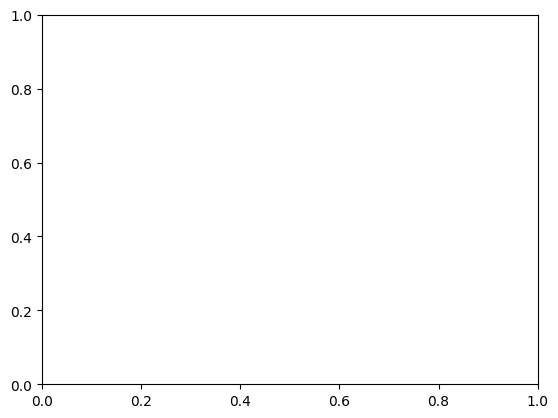

In [25]:
# Save
writer = animation.FFMpegWriter(fps=10)
anim.save('sample_radar_forecast.mp4', writer=writer)